Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [12]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

!pip install --upgrade category_encoders
import category_encoders as ce

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from scipy.stats import randint, uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# Split dataset into training and validation datasets
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, 
                              train_size=0.8, 
                              test_size=0.2, 
                              stratify=train['status_group'], 
                              random_state=42) 

In [0]:
import numpy as np

def wrangle (X):
  
  # Prevent SettingWithCopyWarning
  X = X.copy()
  
  # Prevent null island
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # Replace zeros with nans
  # Add column describing missing values
  cols_with_zero = ['population', 
                    'construction_year',
                    'region_code', 
                    'district_code', 
                    'longitude', 
                    'latitude',
                    'gps_height']
  for col in cols_with_zero:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_Missing'] = X[col].isna()

  # Drop columns with values which never vary
  unusuable_variance = ['id']
  X = X.drop(columns=unusuable_variance)

  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  # Extract datetime components from date_recorded
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day

  # Add column, how many years from construction to present
  X['age'] = X['year_recorded'] - X['construction_year']

  # Add Missing columns for columsnw with many nans
  cols_with_nans = ['funder', 'installer', 'subvillage', 'public_meeting', 
                    'scheme_management', 'scheme_name', 'permit', 'age']
  for col in cols_with_nans:
    X[col+'_Missing'] = X[col].isna()

  # Convert status_group to integer dtype
  if ('status_group' in X.columns):
    le = LabelEncoder()
    X['status_group'] = le.fit_transform(X['status_group'])

  # Return wrangled dataframe
  return X

train_wrangle = wrangle(train)
val_wrangle = wrangle(val)
test_wrangle = wrangle(test)

In [0]:
# Target colunns
target = 'status_group'

# Features columns
train_features = train_wrangle

# Numeric features columns
numeric_features = train_wrangle.select_dtypes(include='number').columns.tolist()

# Obtain cardinality of categorical features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Categorical features with cardinality less than 150
categorical_features = cardinality[cardinality < 50].index.tolist()

# Combine to lists of features
features = numeric_features + categorical_features

# Drop status_group
features.remove('status_group')

In [0]:
# Arrange data into X features and Y label
X_train = train_wrangle[features]
y_train = train_wrangle[target]
X_val = val_wrangle[features]
y_val = val_wrangle[target]
X_test = test_wrangle[features]

In [0]:
param_distributions = {
  'simpleimputer__strategy': ['mean', 'median'],
  'selectkbest__k': range(1, X_train.shape[1]+1), 
  'randomforestclassifier__n_estimators': randint(50, 500), 
  'randomforestclassifier__max_depth': [5, 10, 15, None], 
  'randomforestclassifier__max_features': uniform(0, 1),
  'randomforestclassifier__min_samples_leaf': randint(1, 10),
}

In [17]:
pipeline3 = make_pipeline(
  ce.one_hot.OrdinalEncoder(),
  SimpleImputer(),
  SelectKBest(),
  RandomForestClassifier(n_jobs=-1)
)

search3 = RandomizedSearchCV(
    pipeline3, 
    param_distributions=param_distributions, 
    n_iter=20, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search3.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   50.0s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [18]:
pipeline3 = search3.best_estimator_

y_pred = pipeline3.predict(X_val)
y_pred = pd.Series(y_pred)
accuracy_score(y_pred, y_val)

0.8095117845117845

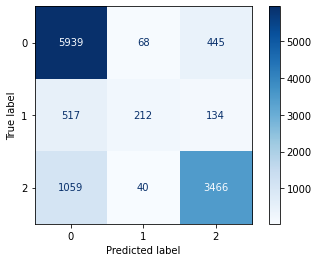

In [28]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline3, 
                      X_val, 
                      y_val,
                      values_format='.0f',
                      cmap='Blues');

In [24]:
y_val

3290     0
47666    0
2538     0
53117    2
51817    2
        ..
9006     2
20942    2
29031    2
3493     2
257      2
Name: status_group, Length: 11880, dtype: int64